In [2]:
import numpy as np
import tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras import losses
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Add
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Multiply
from tensorflow.keras.regularizers import l2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
num_classes = 10

x_train = x_train.astype('float16')
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)

x_test = x_test.astype('float16')
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

mean_image = np.mean(x_train, axis=0)
x_train -= mean_image
x_test -= mean_image

In [5]:
def conv_unit(x, filters, kernel_size, weight_decay=0.0, strides=(1,1)):
    layer = Conv2D(filters, kernel_size, strides, padding='same',
                   use_bias=False, kernel_regularizer=l2(weight_decay)
                  )(x)
    layer = BatchNormalization()(layer)
    return layer

def residual_unit(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        residual_x = conv_unit(x, filters, kernel_size=1, strides=1)
        stride = 1
    else:
        residual_x = x
        stride = 1
    out = conv_unit(x, filters, kernel_size, weight_decay, stride)
    residual = Activation('relu')(out)
    out = Add()([residual_x, residual])
    out = Activation('relu')(out)
    return out


def attention_module(attention_input, p, t, r, filters, weight_decay):
    
    # residual unit * p
    res_out_1 = attention_input
    for i in range(p):
        res_out_1 = residual_unit(res_out_1, filters, (3, 3), weight_decay, downsample=True)
    
    
    #=============================================================================
    # Trunk Branch: residual unit * t
    #============================================================================= 
    trunk_out = res_out_1
    for i in range(t):
        trunk_out = residual_unit(trunk_out, filters, (3, 3), weight_decay, downsample=True)
    
    
    #=============================================================================
    #Soft Mask Branch:
    #=============================================================================
    # Downsampling: Maxpooling
    down_out_1 = MaxPool2D(pool_size=(2, 2),
                          padding='same')(res_out_1)
    
    # residual unit * r
    res_out_2 = down_out_1
    for i in range(r):
        res_out_2 = residual_unit(res_out_2, filters, (3, 3), weight_decay, downsample=True)

    # Downsampling: Maxpooling
    down_out_2 = MaxPool2D(pool_size=(2, 2),
                          padding='same')(res_out_2)
    # residual unit * 2r
    res_out_3 = down_out_2
    for i in range(2*r):
        res_out_3 = residual_unit(res_out_3, filters, (3, 3), weight_decay, downsample=True)

    # Upsampling: interpolation
    up_out_1 = UpSampling2D(size=(2, 2))(res_out_3)
    
    # shortcut
    shortcut_out = residual_unit(res_out_2, filters, (3, 3), weight_decay, downsample=True)
    combine_out_1 = Add()([shortcut_out, up_out_1])
    
    
    # residual unit * r
    res_out_4 = up_out_1
    for i in range(r):
        res_out_4 = residual_unit(combine_out_1, filters, (3, 3), weight_decay, downsample=True)


    # Upsampling: interpolation
    up_out_2 = UpSampling2D(size=(2, 2))(res_out_4)
    
    # Conv * 2
    f = up_out_2.shape[-1]
    conv_out_1 = Conv2D(filters=f,
                         kernel_size=(1,1),
                         padding='same')(up_out_2)
    bn_out = BatchNormalization()(conv_out_1)
        
    conv_out_2 = Conv2D(filters=f,
                   kernel_size=(1,1),
                   padding='same')(bn_out)
    
    # Activation: sigmoid
    mask_out = Activation('sigmoid')(conv_out_2)
    
    
    #=============================================================================
    # Element-wise product and sum of soft mask branch and trunk branch
    #=============================================================================
    # (1+M(x))*T(x)
    combine_out_2 = Multiply()([Lambda(lambda x: 1 + x)(mask_out), trunk_out])
    
    # residual unit * p
    res_out_5 = combine_out_2
    for i in range(p):
        res_out_5 = residual_unit(res_out_5, filters, (3, 3), weight_decay, downsample=True)
    
    attention_input = res_out_5
    
    return attention_input

In [6]:
input_data = Input(shape=(32, 32, 3))

# Conv1
conv_out_1 = Conv2D(filters=32,
                      kernel_size=(3,3),
                      padding='same')(input_data)
# Max pooling        
maxpool_out_1 = MaxPool2D(pool_size=(2, 2),
                          padding='same')(conv_out_1)

# Redisual unit + Attention Module
residual_out_1 = residual_unit(maxpool_out_1, 32, (3, 3), 1e-4)
attention_out_1 = attention_module(residual_out_1, 1, 2, 1, 32, 1e-4)
residual_out_2 = residual_unit(attention_out_1, 64, (3, 3), 1e-4)
attention_out_2 = attention_module(residual_out_2,  1, 2, 1, 64, 1e-4)
residual_out_3 = residual_unit(attention_out_2, 128, (3, 3), 1e-4)
attention_out_3 = attention_module(residual_out_3,  1, 2, 1, 128, 1e-4)
residual_out_4 = residual_unit(attention_out_3, 256, (3, 3), 1e-4)
residual_out_5 = residual_unit(residual_out_4, 256, (3, 3), 1e-4)
residual_out_6 = residual_unit(residual_out_5, 256, (3, 3), 1e-4)

# Avg Pooling
avgpool_out = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(residual_out_6)

# Flatten the data
flatten_out = Flatten()(avgpool_out)

# FC Layers for prediction
fc_out = Dense(512, activation='relu')(flatten_out)
fully_connected_layer_last = Dense(10,activation="softmax")(fc_out)
         
# Fully constructed model
model = Model(inputs=input_data, outputs=fully_connected_layer_last)

In [7]:
# get data
num_train = int(x_train.shape[0] * 0.8)
num_val = x_train.shape[0] - num_train
mask = list(range(num_train, num_train+num_val))
x_val = x_train[mask]
y_val = y_train[mask]

mask = list(range(num_train))
x_train = x_train[mask]
y_train = y_train[mask]

data = (x_train, y_train, x_val, y_val, x_test, y_test)
print("Training data shape: ", x_train.shape)
print("Training label shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test label shape: ", y_test.shape)

Training data shape:  (40000, 32, 32, 3)
Training label shape:  (40000, 10)
Test data shape:  (10000, 32, 32, 3)
Test label shape:  (10000, 10)


In [8]:
model.compile(optimizer=optimizers.SGD(lr=1e-1, 
                                       momentum=0.9, 
                                       nesterov=False),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
def lr_scheduler(epoch):
    new_lr = 1e-1 * (0.1 ** (epoch // 75))
    print('new lr:%.2e' % new_lr)
    return new_lr 

reduce_lr = LearningRateScheduler(lr_scheduler)

datagen = ImageDataGenerator( 
    width_shift_range=0.125,  
    height_shift_range=0.125,
    horizontal_flip=True)

train_gen = datagen.flow(x_train, y_train, batch_size=64)
history = model.fit_generator(generator=train_gen,
                              epochs=200,
                              callbacks=[reduce_lr],
                              validation_data=(x_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
new lr:1.00e-01
625/625 [==============================] - 66s 86ms/step - loss: 15.9913 - accuracy: 0.1007 - val_loss: 12.9816 - val_accuracy: 0.1037
Epoch 2/200
new lr:1.00e-01
625/625 [==============================] - 53s 85ms/step - loss: 12.3466 - accuracy: 0.1074 - val_loss: 10.6075 - val_accuracy: 0.1143
Epoch 3/200
new lr:1.00e-01
625/625 [==============================] - 54s 86ms/step - loss: 10.1173 - accuracy: 0.1116 - val_loss: 8.6968 - val_accuracy: 0.1610
Epoch 4/200
new lr:1.00e-01
625/625 [==============================] - 54s 87ms/step - loss: 8.2285 - accuracy: 0.2068 - val_loss: 7.2900 - val_accuracy: 0.1733
Epoch 5/200
new lr:1.00e-01
625/625 [==============================] - 54s 86ms/step - loss: 6.7032 - accuracy: 0.2641 - val_loss: 6.3266 - val_accuracy: 0.1984
Epoch 6/200
new lr:1.00e-01
625/625 [==============================] - 54s 86ms/step - loss: 5.5926 - accuracy: 0.2918 - val_loss: 4.8772 - val_accuracy: 0.3306
Epoch 7/200
new lr:1.00e-01
6

In [10]:
def plot_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('epoch')
  plt.ylabel('Loss value')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('epoch')
  plt.ylabel('acc value')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

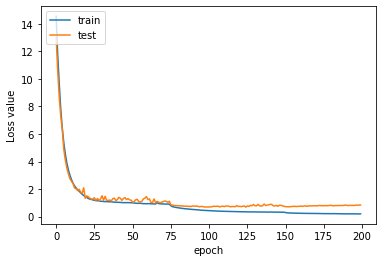

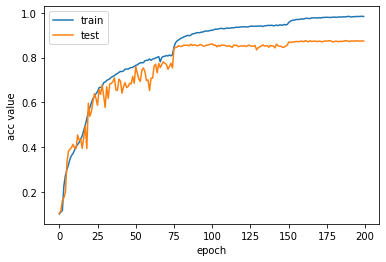

In [11]:
plot_history(history)

In [12]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 14ms/step - loss: 0.9332 - accuracy: 0.8662


[0.9332308769226074, 0.8661999702453613]

In [14]:
model.save('best_model.h5')